# **Deep Face Detection**

## Project Content <a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Checking The Dataset](#3)
4. [Creating a Data Pypeline and Loading The Dataset](#4)

### Second Step: Data Preprocessing

5. [Scaling The Data](#5)
6. [Seperating Data into Three Parts of Train, Validation and Test Sets](#6)
7. [Categorical Fields Analysis](#7)
8. [Feature Scaling](#8)
9. [Seperating Data into Two Parts of Train and Test](#9)

### Third and Final Step: Modeling

7. [Defining Modeling Functions](#7)
8. [Building The Model's Architecture](#8)
9. [First Time Training](#9)
10. [Plotting The Model's Loss and Accuracy](#10)
11. [Model's Performance Evaluation](#11)
12. [Testing The Model](#12)

***

# First Step: First Organization

***

## 1. Introduction <a id = 1></a>

This analysis is focused on the behavior of telecom customers who are more likely to terminate their contracts.

**Fields**
- Demographic information about customers | **Gender, Seniorcitizen, Partnere, Dependents**
- Main services that each customer has signed up for | **Phoneservice, Multiplelines, Internetservice**
- Internet-based services which customers have signed up for | **Onlinesecurity, Onlinebackup, Deviceprotection, Techsupport, and Streamingtv and streamingmovies**
- Customers' accounts information | **Tenure, Monthlycharges, Totalcharges**
- Customers' financial information | **Contract, Paymentmethod, Paperlessbilling**
- Customers who left within the last month | **Churn**

[Project Content](#0)

## 2. Loading libraries and packages to embark our new journey <a id = 2></a>

In [2]:
# Basic Python packages
import os
import uuid
import time
import random

# Numpy library
import numpy as np

# Pandas library and settings
import pandas as pd

# Visualization libraries (Matplotlib, Seaborn)
import matplotlib.pyplot as plt

# Tensorflow library
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
    
# OpenCV
import cv2
import imghdr

# Albumentations
import albumentations as alb

# JSON
import json

%matplotlib inline

[Project Content](#0)

## <font color="red"> 3. Collecting Images </font> <a id = 3></a>

First of all, define the path you want to save your images and the number of them.

In [3]:
images_path = os.path.join("data", "images")

# Define the number of images.
m = 90

<font color="red"> **Run the cells below if you have not collected your images.** </font>

Establish a conncetion with device camera.

In [3]:
capture = cv2.VideoCapture(0)

Now, everything seems fine and it's time to capture the images.

In [4]:
for image_num in range(m):
    
    print(f"Collecting the image {image_num + 1} ...")
    
    # Capture a frame from the camera and generate a unique image path using a UUID and save as JPEG.
    ret, frame = capture.read()
    
    image_path = os.path.join(images_path, f"{str(uuid.uuid1())}.jpeg")
    cv2.imwrite(image_path, frame)
    
    # Display the captured frame.
    cv2.imshow("frame", frame)
    
    # Pause for 2 seconds to change the posture.
    time.sleep(2)
    
    # Check if the "q" key is pressed, and if so, break out of the loop.
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the video capture resources and close all display windows.
capture.release()
cv2.destroyAllWindows()

print("Process finished!")

2023-09-16 10:47:21.954 python[7892:379582] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (2.05 secs).


Process finished!


[Project Content](#0)

## <font color="red"> 4. Labeling Images </font> <a id = 4></a>

<font color="red"> **Run the cell below if you have not labeled your images.** </font>

In [3]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: /Users/shahriyar/.labelmerc
2023-09-16 11:15:27.310 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:20:50.482 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:21:12.238 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:21:13.954 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:21:15.543 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:21:21.285 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:23:13.138 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:23:46.518 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 11:23:53.866 labelme[8300:398862] +[CATransaction synchronize] called within transaction
2023-09-16 

The label json file that is created for each label contains sth like this.</br>
The points will work as data to predict the frame that contains the face.

![Alt text](<Screenshot 1402-07-01 at 10.06.58.png>)

## 5. Reviewing Dataset and Building an Image Loading Function <a id = 5></a>

We have to limit the GPU memory growth by tf, since it will use all of the space of VRAM.

In [4]:
# Create a list of all GPUs available and then print them.
gpus = tf.config.experimental.list_physical_devices("GPU")

print("List of GPUS")
print("-"*70)

for gpu in gpus:
    print(f"{gpus.index(gpu)}: {gpu}")

print("\nEnabling Dynamic Allocation of GPU Memory")
print("-"*70)

# Set up TensorFlow to dynamically allocate GPU memory for each GPU device in a list (gpus)
# to ensure efficient memory utilization and avoid memory allocation issues.
# Dynamic memory allocation means that TensorFlow will allocate GPU memory as needed,
# rather than reserving the entire GPU memory upfront.
for gpu in gpus: 

    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{gpus.index(gpu)}: Dynamic allocation has been enabled.")

List of GPUS
----------------------------------------------------------------------
0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Enabling Dynamic Allocation of GPU Memory
----------------------------------------------------------------------
0: Dynamic allocation has been enabled.


Now it's time to load images into the tensorflow data pypeline.

In [ ]:
# Create a TensorFlow Dataset from a list of image file paths, without shuffling them.
images = tf.data.Dataset.list_files("data/images/*.jpeg", shuffle=False)

print(images)

Now, everyhing is fine and we can load and check the images.

In [6]:
def load_image(image_path):
    
    """Reads an image file from the given file path and decodes it into a TensorFlow tensor.

    Args:
        image_path (str): The file path of the image to be loaded.

    Returns:
        decoded_image (tensor): A TensorFlow tensor representing the image.
    """
    
    # Read the image file located at "image_path", and store it as a byte tensor.
    byte_image = tf.io.read_file(image_path)

    # Decode the byte tensor "byte_image" into an image tensor "decoded_image", assuming it's in JPEG format.
    decoded_image = tf.io.decode_jpeg(byte_image)
    
    return decoded_image

Map function will run load image function on each object of the dataset which are passed to pypeline.

In [14]:
# Map the load_image function to each element in the images dataset,
# transforming the dataset by applying load_image to each element.
images = images.map(load_image)

And the last step before viewing the images is to batching them for model's input.

In [31]:
# Create an image generator that batches images into groups of 4,
# and convert them to NumPy arrays for efficient processing.
image_generator = images.batch(4).as_numpy_iterator()

Let's check how these batches are formed.

In [32]:
i = 0

for batch in image_generator:
    
    print(f"Batch {i + 1}: {batch.shape}")
    i += 1

Batch 1: (4, 720, 1280, 3)
Batch 2: (4, 720, 1280, 3)
Batch 3: (4, 720, 1280, 3)
Batch 4: (4, 720, 1280, 3)
Batch 5: (4, 720, 1280, 3)
Batch 6: (4, 720, 1280, 3)
Batch 7: (4, 720, 1280, 3)
Batch 8: (4, 720, 1280, 3)
Batch 9: (4, 720, 1280, 3)
Batch 10: (4, 720, 1280, 3)
Batch 11: (4, 720, 1280, 3)
Batch 12: (4, 720, 1280, 3)
Batch 13: (4, 720, 1280, 3)
Batch 14: (4, 720, 1280, 3)
Batch 15: (4, 720, 1280, 3)
Batch 16: (4, 720, 1280, 3)
Batch 17: (4, 720, 1280, 3)
Batch 18: (4, 720, 1280, 3)
Batch 19: (4, 720, 1280, 3)
Batch 20: (4, 720, 1280, 3)
Batch 21: (4, 720, 1280, 3)
Batch 22: (4, 720, 1280, 3)
Batch 23: (2, 720, 1280, 3)


Now we can visualize these images.

* Remember to assign the variable again in order to make the itteration alive.

In [34]:
image_generator = images.batch(4).as_numpy_iterator()

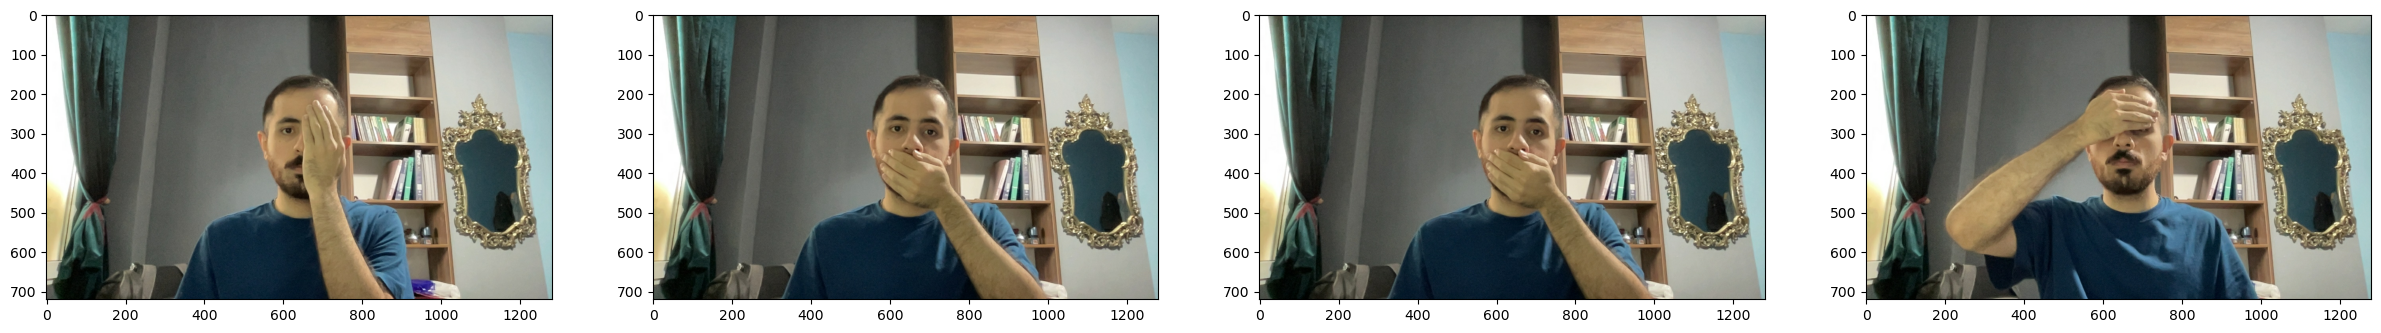

In [39]:
fig, axes = plt.subplots(ncols=4, figsize=(30, 20))

for index, image in enumerate(image_generator.next()):
    axes[index].imshow(image)

[Project Content](#0)

***

# Second Step: Data Preprocessing

***

## <font color="red">6. Partitioning Unaugmented Data into Three Parts of Train, Validation and Test Sets</font> <a id = 6></a>

First things first, we must determine the number of images in each set.

In [7]:
# Define the target directories where image files will be moved.
images_destination_directories = ["data/train/images",
                                  "data/validation/images",
                                  "data/test/images"]

# Define the proportions for splitting the image files into train, validation, and test sets.
proportions = [0.75, 0.15, 0.10]

# List all the image files in the source directory, and then shuffle them.
images_list = os.listdir(images_path)
random.shuffle(images_list)

# Calculate the total number of image files and the number of files to move to each destination directory.
num_files = len(images_list)
num_destination_files = [int(num_files * proportion) for proportion in proportions]

# Adjust the number of files in the last directory to ensure no files are missed.
if sum(num_destination_files) != m:
    num_destination_files[-2] += 1

print(f"Train set size: {num_destination_files[0]}")
print(f"Validation set size: {num_destination_files[1]}")
print(f"Test set size: {num_destination_files[2]}")
print(25*"-")
print(sum(num_destination_files))

Train set size: 0
Validation set size: 1
Test set size: 0
-------------------------
1


<font color="red"> **Now, we should move the images.** </font>

In [48]:
# Initialize the start index for iterating through the shuffled list of image files.
start_index = 0

# Loop through the destination directories and move the appropriate number of image files to each.
for directory_index, directory in enumerate(images_destination_directories):
    
    # Calculate the end index for the current destination directory.
    end_index = start_index + num_destination_files[directory_index]
    
    # Select the images to move for the current directory
    images_to_move = images_list[start_index:end_index]
        
    # Iterate through the selected images and move them from the source to the destination.
    for image in images_to_move:
        
        source_path = os.path.join(images_path, image)
        destination_path = os.path.join(directory, image)
        
        # Rename (move) the image from the source to the destination directory.
        os.rename(source_path, destination_path)
    
    # Update the start index for the next destination directory.
    start_index = end_index

# Print a message to indicate that image files have been moved successfully
print("Image files moved successfully!")

Image files moved successfully!


Define the labels' path.

In [11]:
# Define the path where label files are located, and destination directories for labels.

labels_path = os.path.join("data", "labels")
labels_destination_directories = ["data/train/labels",
                                  "data/validation/labels",
                                  "data/test/labels"]

<font color="red"> **And now, we can move the labels based on the images.** </font>

In [ ]:
# Loop through each destination directory.
for directory_index, directory in enumerate(images_destination_directories):
        
    # List all images in the current destination directory.
    images_list = os.listdir(directory)
    
    # Iterate through each image in the directory.
    for image in images_list:
                
        # Generate the corresponding label filename and Create the source path for the label file.
        label_to_move = image.split(".")[0] + ".json"        
        source_path = os.path.join(labels_path, label_to_move)      
        
        # Check if the label file exists in the source directory.
        if os.path.exists(source_path):
        
            # Create the destination path for the label file based on the current destination directory,
            # and then move (rename) the label file from the source to the destination.
            destination_path = os.path.join(labels_destination_directories[directory_index], label_to_move)
            os.rename(source_path, destination_path)
        
# Print a message indicating that label files have been moved successfully
print("Label files moved successfully!")

Label files moved successfully!


## <font color="orange">7. Applying Image Augmentation on Images and Labels</font> <a id = 7></a>

Now, we want to augement the images in each set of train, validation and test sets.</br>
Firstly, we have to create an augmentation pypeline.

In [12]:
# Create an augmentation pipeline using the Albumentations library.
augmentor = alb.Compose([
    # Randomly crop the image to a width and height of 450 pixels.
    alb.RandomCrop(width=450, height=450),

    # Apply horizontal flipping with a probability of 50%.
    alb.HorizontalFlip(p=0.5),

    # Apply random brightness and contrast adjustments with a probability of 20%.
    alb.RandomBrightnessContrast(p=0.2),

    # Apply random gamma adjustments with a probability of 20%.
    alb.RandomGamma(p=0.2),

    # Apply random RGB color shifts with a probability of 20%.
    alb.RGBShift(p=0.2),

    # Apply vertical flipping with a probability of 50%.
    alb.VerticalFlip(p=0.5)
    ],

    # Define bounding box parameters for use in object detection tasks.
    bbox_params=alb.BboxParams(
        format="albumentations",  # Format of bounding box annotations.
        label_fields=["class_labels"]  # Field containing class labels for each bounding box.
    ))

Let's check the pypeline for an image and its annonation.

In [20]:
image = cv2.imread(os.path.join(images_destination_directories[0], "0dd0e6b8-5461-11ee-820b-5e8f2d19bd87.jpeg"))

print(f"Image shape is")
print(15*"-")
print(image.shape)
print()

print(f"Image")
print(15*"-")
print(image)

Image shape is
---------------
(720, 1280, 3)

Image
---------------
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [171 176 167]
  [170 174 168]
  [171 175 169]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [170 175 166]
  [169 173 167]
  [168 172 166]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [173 178 169]
  [171 175 169]
  [169 173 167]]

 ...

 [[ 81  85  80]
  [ 86  90  85]
  [ 76  80  75]
  ...
  [186 185 147]
  [186 187 148]
  [187 188 149]]

 [[ 84  88  83]
  [ 82  86  81]
  [ 81  85  80]
  ...
  [184 183 145]
  [183 184 145]
  [184 185 146]]

 [[ 70  74  69]
  [ 71  75  70]
  [ 79  83  78]
  ...
  [182 181 143]
  [182 183 144]
  [184 185 146]]]


In [21]:
with open(os.path.join(labels_destination_directories[0], "0dd0e6b8-5461-11ee-820b-5e8f2d19bd87.json"), "r") as label_file:
    label = json.load(label_file)
    
print("Image's label details")
print(25*"-")

for key in label.keys():
    print(f"{key}: {label[key]}")
    
print("\nImage's label points")
print(25*"-")
print(label["shapes"][0]["points"])

Image's label details
-------------------------
version: 4.5.12
flags: {}
shapes: [{'label': 'face', 'points': [[544.5238095238095, 129.76190476190476], [788.3333333333333, 468.80952380952374]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}}]
imagePath: ../images/0dd0e6b8-5461-11ee-820b-5e8f2d19bd87.jpeg
imageData: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5

We want to extract the vector of the points from each label, so let's do that.

In [36]:
coordinates = [0, 0, 0, 0]
# x1, y1, x2, y2

coordinates[0] = label["shapes"][0]["points"][0][0]
coordinates[1] = label["shapes"][0]["points"][0][1]
coordinates[2] = label["shapes"][0]["points"][1][0]
coordinates[3] = label["shapes"][0]["points"][1][1]

coordinates

[544.5238095238095, 129.76190476190476, 788.3333333333333, 468.80952380952374]

Before going further, let's check the image and its annonations.

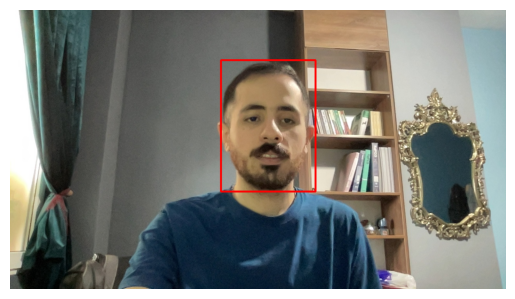

In [39]:
# Convert BGR to RGB color format.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the four corner coordinates of the rectangle (x, y) for the top-left and (x, y) for the bottom-right.
coordinates = (int(coordinates[0]),
               int(coordinates[1]),
               int(coordinates[2]),
               int(coordinates[3]))  # (x1, y1, x2, y2)

# Define the color and the thickness of the rectangle.
color = (0, 0, 255)    
thickness = 3
    
# Draw the rectangle on the image.
image_with_rectangle = cv2.rectangle(image.copy(), (coordinates[0], coordinates[1]), (coordinates[2], coordinates[3]), color, thickness)
    
# Convert BGR to RGB color format.
image_with_rectangle_rgb = cv2.cvtColor(image_with_rectangle, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib.
plt.imshow(image_with_rectangle_rgb)
plt.axis("off")
plt.show()

As we want to use normalized albumanisation, we have to divide the image's annonation x and y by the width and height of the image.</br>
Meaning that we have to rescale it to match the image resolution.

In [43]:
coordinates = [0, 0, 0, 0]

coordinates[0] = label["shapes"][0]["points"][0][0]
coordinates[1] = label["shapes"][0]["points"][0][1]
coordinates[2] = label["shapes"][0]["points"][1][0]
coordinates[3] = label["shapes"][0]["points"][1][1]

image_height, image_width, _ = image.shape

coordinates[0] /= image_width
coordinates[1] /= image_height
coordinates[2] /= image_width
coordinates[3] /= image_height

coordinates

[0.42540922619047616,
 0.18022486772486773,
 0.6158854166666666,
 0.6511243386243385]

Now, we can apply the augmentation and check the results.

In [48]:
augmented_image = augmentor(image=image,
                            bboxes=[coordinates],
                            class_labels=["face"])

print("Augmented image has these keys")
print(40*"-")
print()

for key in augmented_image.keys():
    print(key)
    print(10*"-")
    print(f"\n{augmented_image[key]}")
    print()

Augmented image has these keys
----------------------------------------

image
----------

[[[143 156 130]
  [136 149 128]
  [124 139 122]
  ...
  [123 126 124]
  [119 122 120]
  [117 120 118]]

 [[145 156 128]
  [137 150 128]
  [125 141 121]
  ...
  [120 123 121]
  [119 122 120]
  [117 120 118]]

 [[143 155 125]
  [136 150 125]
  [128 142 122]
  ...
  [118 121 119]
  [117 120 118]
  [116 119 117]]

 ...

 [[171 191 189]
  [164 184 180]
  [135 154 146]
  ...
  [ 73  49  15]
  [ 76  53  19]
  [ 70  47  12]]

 [[171 190 188]
  [158 176 171]
  [128 144 136]
  ...
  [ 68  45   9]
  [ 75  52  18]
  [ 73  49  15]]

 [[161 178 175]
  [143 158 151]
  [ 99 114 104]
  ...
  [ 72  47  15]
  [ 78  54  24]
  [ 76  53  19]]]

bboxes
----------

[]

class_labels
----------

[]



Let's check the augmented image and its original format.

IndexError: list index out of range

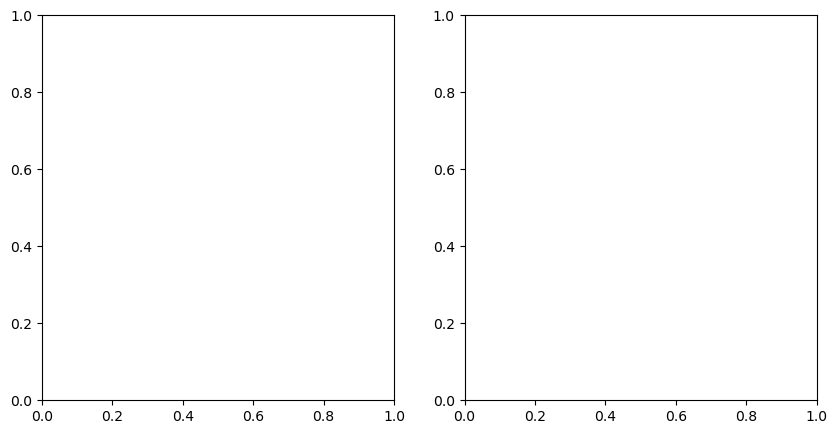

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

cv2.rectangle(augmented_image["image"],
              tuple(np.multiply(augmented_image["bboxes"][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented_image["bboxes"][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(augmented_image["image"], cv2.COLOR_BGR2RGB))

<font color="orange"> **Now, everything is ok and we can build and run the augmentation pypeline.** </font>

In [33]:
for partition in ["train", "test", "validation"]: 
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join("data", partition, "labels", f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)

            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            
            img_height, img_width, _ = img.shape

            coords[0] /= image_width
            coords[1] /= image_height
            coords[2] /= image_width
            coords[3] /= image_height

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
                cv2.imwrite(os.path.join("aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), augmented["image"])

                annotation = {}
                annotation["image"] = image

                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0: 
                        annotation["bbox"] = [0, 0, 0, 0]
                        annotation["class"] = 0 
                    else: 
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else: 
                    annotation["bbox"] = [0, 0, 0, 0]
                    annotation["class"] = 0 


                with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6636088709677419, 0.08920250896057347, 0.4727066532258065, 0.5517921146953405, 'face'].
x_max is less than or equal to x_min for bbox [0.6667590725806452, 0.07352150537634408, 0.4859375, 0.49578853046594984, 'face'].
y_max is less than or equal to y_min for bbox [0.5060987903225806, 0.5909946236559139, 0.91484375, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.4349042338709677, 0.36698028673835126, 0.6610887096774194, 0.15752688172043008, 'face'].
y_max is less than or equal to y_min for bbox [0.0014364919354838712, 0.548431899641577, 0.1734375, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6182459677419355, 0.14296594982078853, 0.514289314516129, 0.5170698924731183, 'face'].
x_max is less than or equal to x_min for bbox [0.6056451612903226, 0.48458781362007175, 0.4588457661290323, 0.16312724014336916, 'face'].
image must be numpy array type
x_max is less than or equal to x_min for bbox [0.656048387096774

## 8. Preparing Images and Labels Datasets <a id = 8></a>

Now, we shuffle the data and get some images from each augmented folder using wild card search.</br>
Map function will run load image function on each object of the dataset which are passed to the pypeline.</br>
And for the last step, we compress each image more to get the neural network as efficient as possible.
We also scale each image before ending this process.

In [13]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [14]:
validation_images = tf.data.Dataset.list_files("aug_data/validation/images/*.jpg", shuffle=False)
validation_images = validation_images.map(load_image)
validation_images = validation_images.map(lambda x: tf.image.resize(x, (120, 120)))
validation_images = validation_images.map(lambda x: x/255)

In [15]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

The variables above are the kind of objects which can be iterated over using the numpy iterator and next functions.

Now, we have to build a label loading function.

In [16]:
def load_labels(label_path):
    
    with open(label_path.numpy(), "r", encoding="utf-8") as file:
        label = json.load(file)
        
    return [label["class"], label["bbox"]]    

Now, we can load labels to tensorflow dataset.

In [17]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
validation_labels = tf.data.Dataset.list_files("aug_data/validation/labels/*.json", shuffle=False)
validation_labels = validation_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

The variables above are the kind of objects which can be iterated over using the numpy iterator and next functions.

Now we should combine the images and labels.

In [20]:
print(f"Train images quantity : {len(train_images)}")
print(f"Train labels quantity : {len(train_labels)}")
print("-"*40)

print(f"Validation images quantity : {len(validation_images)}")
print(f"Validation labels quantity : {len(validation_labels)}")
print("-"*40)

print(f"Test images quantity : {len(test_images)}")
print(f"Test labels quantity : {len(test_labels)}")

Train images quantity : 3180
Train labels quantity : 3180
----------------------------------------
Validation images quantity : 540
Validation labels quantity : 540
----------------------------------------
Test images quantity : 360
Test labels quantity : 360


Now we have to create the final datasets.

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
validation = tf.data.Dataset.zip((validation_images, validation_labels))
validation = validation.shuffle(1300)
validation = validation.batch(8)
validation = validation.prefetch(4)

In [23]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

Now, let's check what have we done!

Firstly, we have to make the dataset object as an iterated one.

In [24]:
data_samples = train.as_numpy_iterator()

data_samples

Let's get through that and check the images and their labels.

In [25]:
results = data_samples.next()

print(f"The results variable has {len(results)} items.\n")

print(f"First the images. For example the first one from {len(results[0])}")
print("-"*50)
print(results[0][0])

print("\nAnd then the labels")
print("-"*50)
print(results[1][0])

print("\nAnd then the annonations")
print("-"*50)
print(results[1][1])

2023-05-22 09:54:17.629328: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


The results variable has 2 items.

First the images. For example the first one from 8
--------------------------------------------------
[[[0.5182598  0.5167279  0.50306374]
  [0.5971201  0.58927697 0.60202205]
  [0.5685662  0.57150733 0.5876838 ]
  ...
  [0.76893383 0.77677697 0.7257966 ]
  [0.7162377  0.72408086 0.6691789 ]
  [0.7117034  0.71954656 0.6655637 ]]

 [[0.5338848  0.5370098  0.5212622 ]
  [0.60851717 0.60851717 0.60949755]
  [0.5836397  0.58020836 0.5983456 ]
  ...
  [0.750674   0.75851715 0.70753676]
  [0.7273284  0.73517156 0.6803309 ]
  [0.70490193 0.7127451  0.6602941 ]]

 [[0.52009803 0.5397059  0.51617646]
  [0.58682597 0.5936887  0.5833946 ]
  [0.57077205 0.57077205 0.5786152 ]
  ...
  [0.7500613  0.7579044  0.706924  ]
  [0.71066177 0.7185049  0.6675245 ]
  [0.71593136 0.71887255 0.66887254]]

 ...

 [[0.04987745 0.20379902 0.3425245 ]
  [0.08645833 0.22714461 0.36930147]
  [0.03529412 0.19031863 0.32849264]
  ...
  [0.20943627 0.20943627 0.17022058]
  [0.19442402

For example the first four images of this batch are the pictures below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


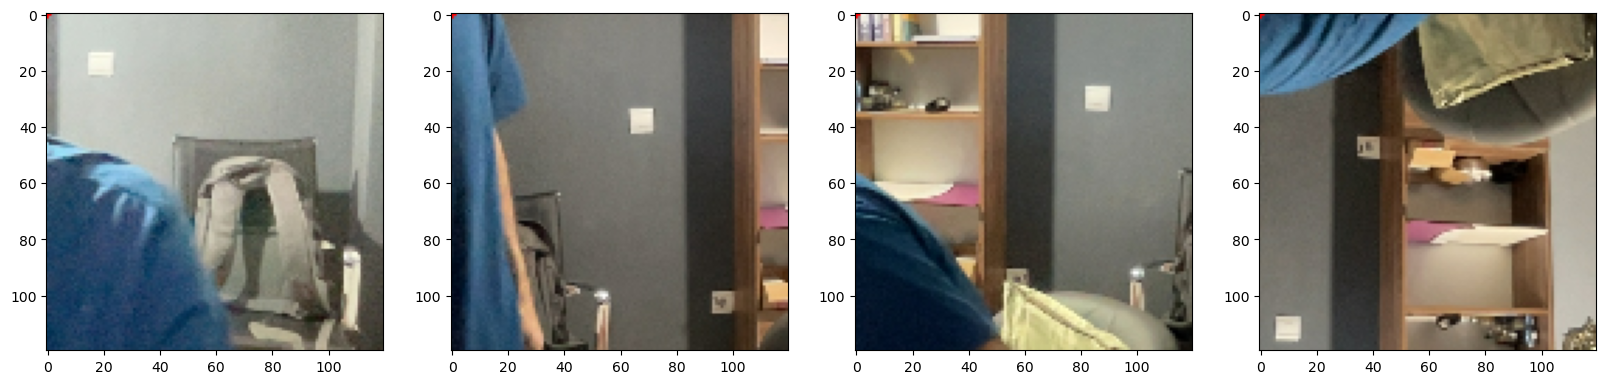

In [26]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 20))

for i in range(4):
    sample_image = results[0][i]
    sample_coords = results[1][1][i]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)
    
    axes[i].imshow(sample_image)

***

# Third and Final Step: Modeling

***

## 9. Creating The Model's Architecture <a id = 9></a>

In [27]:
vgg = VGG16(include_top=False)

In [28]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [29]:
def get_model():
    
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model
    f1 = GlobalAveragePooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)

    # Regression Model
    f2 = GlobalAveragePooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker

In [30]:
facetracker = get_model()

In [31]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg16[0][0]']                  
 alAveragePooling2D)                                                                          

## 10. Determining The Loss and Optimizer <a id = 10></a>

Now, we should define learning rate decay and optimizer.

In [39]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

print(f"Each epoch train {batches_per_epoch} batches.")
print(f"Learning rate decay is {lr_decay}")

Each epoch train 398 batches.
Learning rate decay is 0.0008375209380234504


In [43]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

And then, we need to define localization and classification loss.

In [44]:
def localization_loss(y_true, y_hat):
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_true[:,3] - y_true[:,1]
    w_pred = y_true[:,2] - y_true[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    
    return delta_coord + delta_size

In [45]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
regression_loss = localization_loss

## 11. Building The Training Pypeline <a id = 11></a>

In [46]:
class FaceTracker(Model): 
    
    def __init__(self, facetracker,  **kwargs): 
        
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classification_loss, regression_loss, **kwargs):
        
        super().compile(**kwargs)
        self.closs = classification_loss
        self.lloss = regression_loss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            
            classes, coords = self.model(X, training=True)
            
            batch_classification_loss = self.closs(y[0], classes)
            batch_regression_loss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_regression_loss + 0.5 * batch_classification_loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classification_loss, "regress_loss":batch_regression_loss}
    
    def test_step(self, batch, **kwargs): 
        
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classification_loss = self.closs(y[0], classes)
        batch_regression_loss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_regression_loss + 0.5 * batch_classification_loss
        
        return {"total_loss":total_loss, "class_loss":batch_classification_loss, "regress_loss":batch_regression_loss}
        
    def call(self, X, **kwargs): 
        
        return self.model(X, **kwargs)

In [47]:
model = FaceTracker(facetracker)

## 12. Compiling and Training <a id = 12></a>

In [48]:
model.compile(opt, classification_loss, regression_loss)

In [49]:
log_directory = "logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [52]:
history = model.fit(train, epochs=10, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/10
398/398 [==============================] - 120s 289ms/step - total_loss: 0.4181 - class_loss: 0.2221 - regress_loss: 0.3071 - val_total_loss: 0.5216 - val_class_loss: 0.9217 - val_regress_loss: 0.0608
Epoch 2/10
398/398 [==============================] - 119s 287ms/step - total_loss: 0.2115 - class_loss: 0.1084 - regress_loss: 0.1573 - val_total_loss: 0.1824 - val_class_loss: 0.0690 - val_regress_loss: 0.1479
Epoch 3/10
398/398 [==============================] - 116s 279ms/step - total_loss: 0.1643 - class_loss: 0.0859 - regress_loss: 0.1214 - val_total_loss: 0.0283 - val_class_loss: 0.0291 - val_regress_loss: 0.0137
Epoch 4/10
398/398 [==============================] - 130s 309ms/step - total_loss: 0.0977 - class_loss: 0.0516 - regress_loss: 0.0719 - val_total_loss: 0.1795 - val_class_loss: 0.3515 - val_regress_loss: 0.0037
Epoch 5/10
398/398 [==============================] - 125s 299ms/step - total_loss: 0.0814 - class_loss: 0.0396 - regress_loss: 0.0616 - val_total_loss:

## 13. Plotting The Models's Performance <a id = 10></a>

In [54]:
pd.DataFrame(history.history)

,total_loss,class_loss,regress_loss,val_total_loss,val_class_loss,val_regress_loss
0,0.038933,0.025891,0.025988,0.521638,0.921674,0.060802
1,0.374759,0.312509,0.218505,0.182373,0.068972,0.147887
2,0.028380,0.000990,0.027885,0.028252,0.029133,0.013685
3,0.000996,0.001892,0.000050,0.179472,0.351531,0.003707
4,0.039518,0.000345,0.039346,0.038806,0.012733,0.032440
5,0.002957,0.003776,0.001069,0.009015,0.012399,0.002816
6,0.008778,0.000028,0.008765,0.000084,0.000164,0.000002
7,0.006012,0.000029,0.005998,0.544797,0.296576,0.396509
8,0.028051,0.002175,0.026963,0.189956,0.005412,0.187250
9,0.012811,0.000234,0.012694,0.198521,0.000595,0.198223


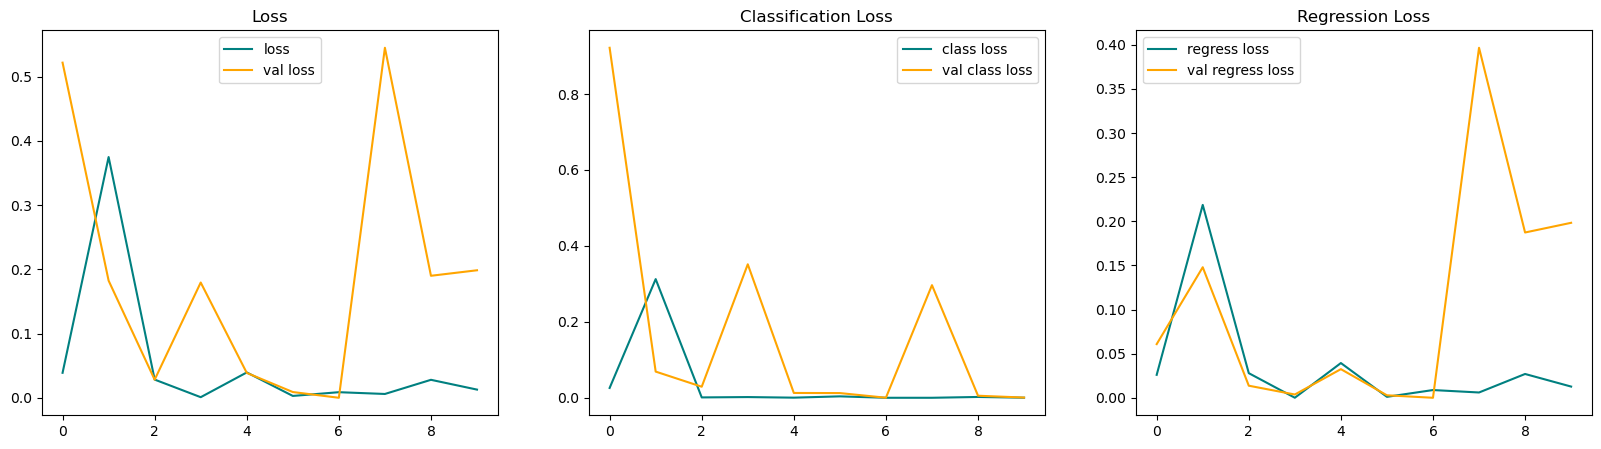

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history["total_loss"], color="teal", label="loss")
ax[0].plot(history.history["val_total_loss"], color="orange", label="val loss")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["class_loss"], color="teal", label="class loss")
ax[1].plot(history.history["val_class_loss"], color="orange", label="val class loss")
ax[1].title.set_text("Classification Loss")
ax[1].legend()

ax[2].plot(history.history["regress_loss"], color="teal", label="regress loss")
ax[2].plot(history.history["val_regress_loss"], color="orange", label="val regress loss")
ax[2].title.set_text("Regression Loss")
ax[2].legend()

plt.show()

## 14. Testing The Model <a id = 14></a>

In [88]:
test_data = test.as_numpy_iterator()

In [104]:
tes_sample = test_data.next()

In [105]:
y_hat = facetracker.predict(tes_sample[0])

1/1 [==============================] - 0s 20ms/step


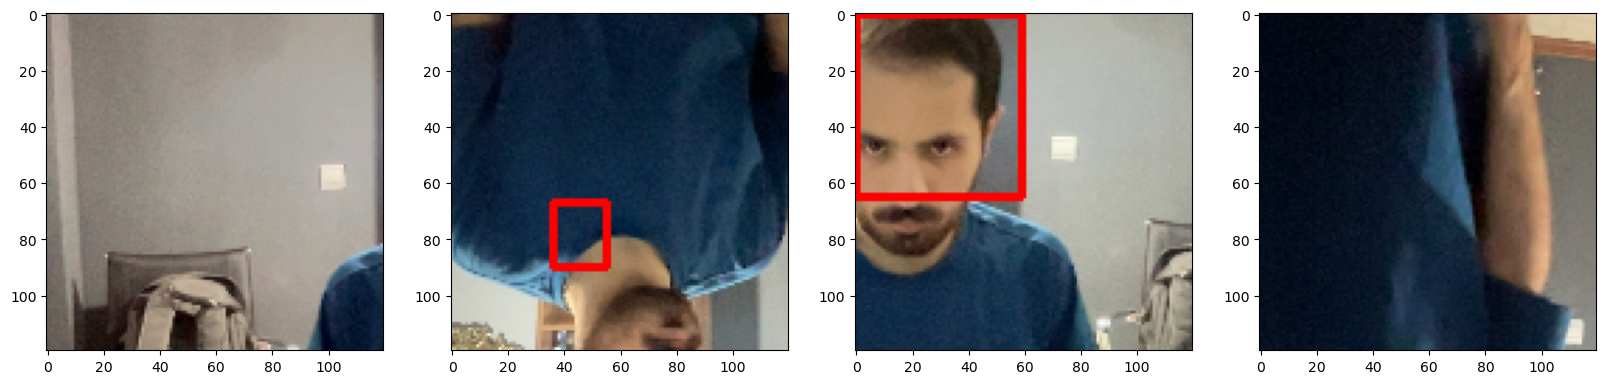

In [106]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = tes_sample[0][idx]
    sample_coords = y_hat[1][idx]
    
    if y_hat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 15. Saving The Model <a id = 15></a>

In [1]:
facetracker.save("facetracker.h5")

NameError: name 'facetracker' is not defined

## 16. Real Time Face Detection <a id = 16></a>

In [ ]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()